# 06.04 - Features - Seasonality

 + Imports & Setup
 + Load Daily Data & Inspect
 + Custom Time Series Cross Validation
 + Scikit-Learn Wrapper for statsmodels SARIMAX
 + Scikit-Learn Wrapper for fbProphet
 + Custom Scikit-Learn Scoring Metric
 + Custom Scikit-Learn Baseline Model
 + Test Scikit-Learn Pipeline Using Custom Objects

## Imports & setup

In [1]:
import pathlib
from datetime import datetime
import math
import sys

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns

sys.path.append("..")
from src.utils.utils import bound_precision, AnnualTimeSeriesSplit
from src.visualization.visualize import (plot_prediction,
                                         plot_joint_plot,
                                         residual_plots,
                                         print_residual_stats,
                                         seasonal_plot)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'


pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Load Daily Data & Inspect

In [2]:
df_orig = pd.read_csv(CLEAN_DATA_DIR / 'clean-features.csv', parse_dates=True, index_col=0)

In [3]:
df_orig.head()

,hmdxx_min,hmdxx_max,hmdxx_median-1,hmdxx_max_hour,temp_min,temp_max,dew_point_temp_max,sun_rise,sun_set,visibility_mean,day_of_week,week_of_year,day_type,daily_peak
1994-05-24,8.998045,19.818202,19.655075,15.0,9.0,19.6,13.4,6.0,21.0,24.975000,1.0,21.0,2,16173.0
1994-05-25,11.406291,20.665711,17.205396,18.0,10.4,18.2,14.0,6.0,21.0,9.358333,2.0,21.0,0,16017.0
1994-05-26,2.563201,15.259916,17.722172,2.0,3.9,13.0,12.3,6.0,21.0,9.650000,3.0,21.0,0,16656.0
1994-05-27,-0.012865,12.970553,6.567827,17.0,2.0,14.8,2.3,6.0,21.0,34.500000,4.0,21.0,0,16252.0
1994-05-30,13.632519,30.133976,18.724332,14.0,13.1,27.2,13.6,6.0,21.0,22.270833,0.0,22.0,0,16525.0


In [4]:
df_orig.tail()

,hmdxx_min,hmdxx_max,hmdxx_median-1,hmdxx_max_hour,temp_min,temp_max,dew_point_temp_max,sun_rise,sun_set,visibility_mean,day_of_week,week_of_year,day_type,daily_peak
2018-10-01,7.548996,13.718202,11.013424,23.0,7.8,12.3,10.3,8.0,19.0,16.291667,0.0,40.0,0,16531.0
2018-10-02,9.447222,15.264688,9.228735,14.0,9.2,12.9,12.2,8.0,19.0,10.729167,1.0,40.0,0,16772.0
2018-10-03,12.186593,20.369401,12.113850,23.0,11.0,16.4,15.0,8.0,19.0,22.966667,2.0,40.0,0,16212.0
2018-10-04,6.612192,30.070535,15.509242,4.0,7.9,22.5,20.5,8.0,19.0,23.433333,3.0,40.0,0,16061.0
2018-10-05,3.412831,12.228666,19.348456,23.0,5.4,12.1,7.3,8.0,19.0,24.100000,4.0,40.0,0,16269.0


In [5]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2400 entries, 1994-05-24 to 2018-10-05
Data columns (total 14 columns):
hmdxx_min             2400 non-null float64
hmdxx_max             2400 non-null float64
hmdxx_median-1        2400 non-null float64
hmdxx_max_hour        2400 non-null float64
temp_min              2400 non-null float64
temp_max              2400 non-null float64
dew_point_temp_max    2400 non-null float64
sun_rise              2400 non-null float64
sun_set               2400 non-null float64
visibility_mean       2400 non-null float64
day_of_week           2400 non-null float64
week_of_year          2400 non-null float64
day_type              2400 non-null int64
daily_peak            2400 non-null float64
dtypes: float64(13), int64(1)
memory usage: 281.2 KB


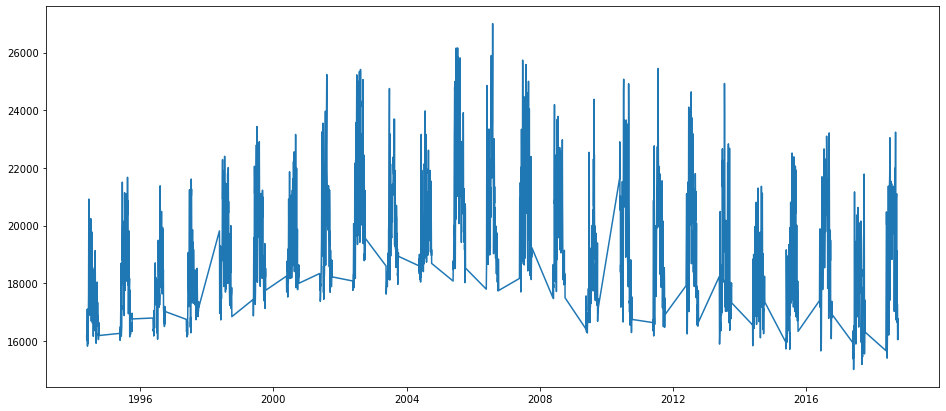

In [6]:
df = df_orig.copy(deep=True)
df = df.loc['1994': '2018']
fig, ax = plt.subplots(figsize=(16,7))
ax.plot(df['daily_peak'])
plt.show();


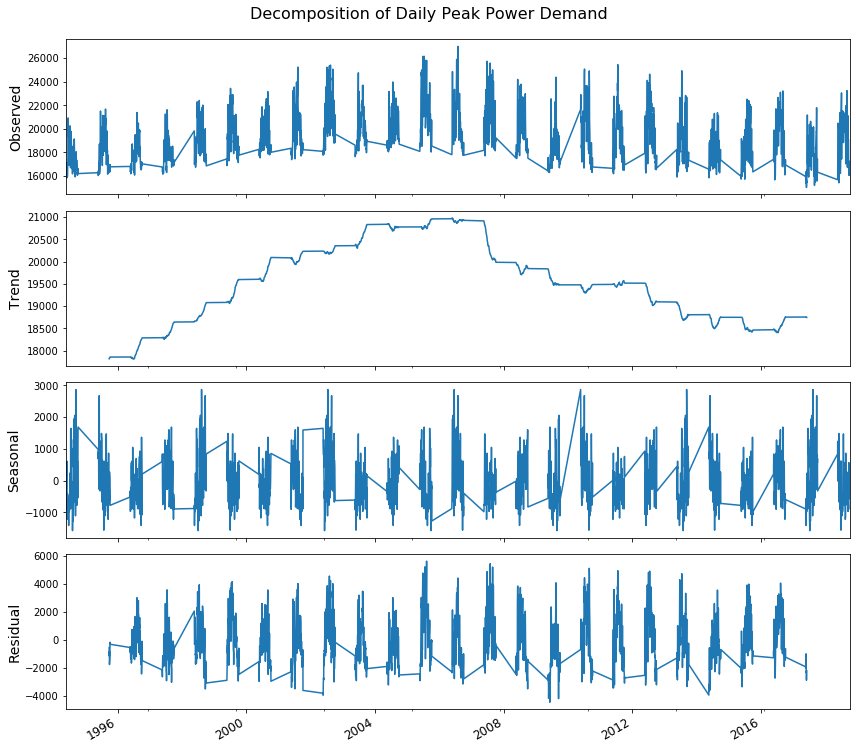

In [7]:
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed', fontsize=14)
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend', fontsize=14)
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal', fontsize=14)
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual', fontsize=14)



fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,10))

# Perform additive decomposition
decomp = seasonal_decompose(df['daily_peak'], freq=365)

plotseasonal(decomp, axes[:])

plt.tight_layout()
plt.suptitle('Decomposition of Daily Peak Power Demand', y=1.03, fontsize=16)
plt.xticks(fontsize=12)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'decomp-plots.PNG', bbox_inches='tight')
plt.show()

### Decomposition with Date Gaps Removed

It is a bit confusing to print these plots with the gaps.

We know the each summer season is 96 days long, so we can index the peak power values to sequential integers and re-run the decomposition function.

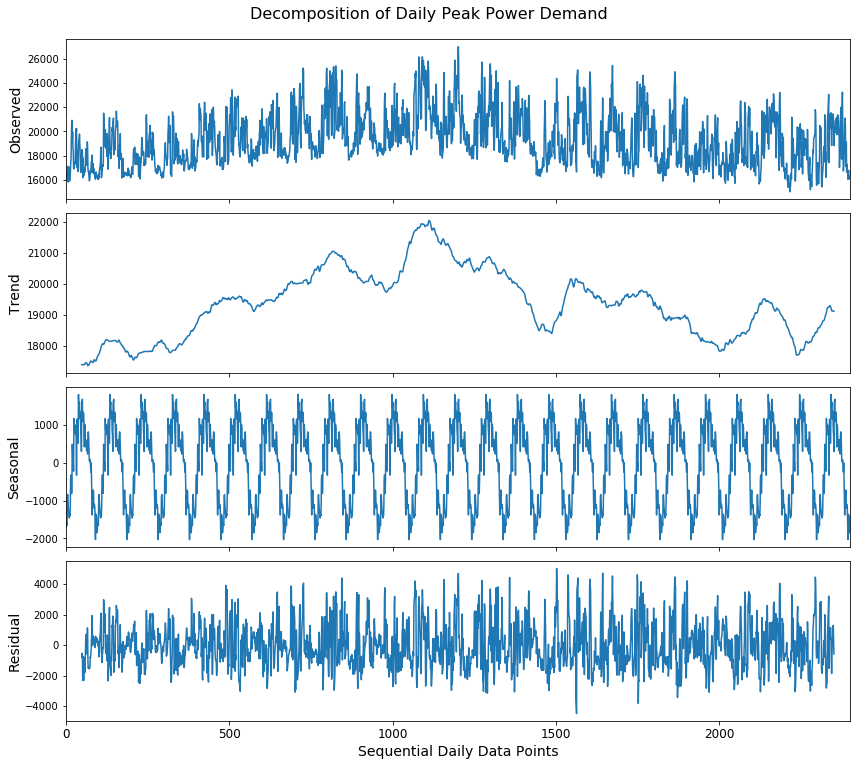

In [8]:
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed', fontsize=14)
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend', fontsize=14)
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal', fontsize=14)
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual', fontsize=14)



fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,10))


# Perform additive decomposition
decomp = seasonal_decompose(df.reset_index()['daily_peak'], freq=96)

plotseasonal(decomp, axes[:])

plt.tight_layout()
axes[3].set_xlabel('Sequential Daily Data Points', fontsize=14)
plt.suptitle('Decomposition of Daily Peak Power Demand', y=1.03, fontsize=16)
plt.xticks(fontsize=12)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'decomp-plots-nodates.PNG', bbox_inches='tight')
plt.show()

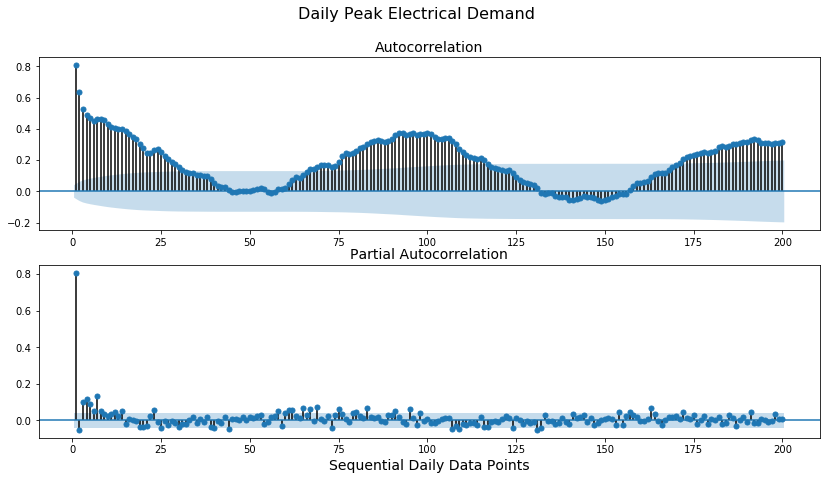

In [9]:
# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14, 7))

# Plot the ACF on ax1
plot_acf(df.reset_index()['daily_peak'], lags=200, zero=False, ax=ax1)
ax1.set_title('Autocorrelation', fontsize=14)
# Plot the PACF on ax2
plot_pacf(df.reset_index()['daily_peak'], lags=200, zero=False, ax=ax2)
ax2.set_title('Partial Autocorrelation', fontsize=14)
ax2.set_xlabel('Sequential Daily Data Points', fontsize=14)
plt.suptitle('Daily Peak Electrical Demand', fontsize=16)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'corr-plots.PNG', bbox_inches='tight')
plt.show();

In [10]:
# Subtract the rolling mean
df2 = df['daily_peak'] - df['daily_peak'].rolling(30).mean()

# Drop the NaN values
df2 = df2.dropna()

In [11]:
df2.head()

1994-07-05    1717.566667
1994-07-06    2620.466667
1994-07-07    2136.066667
1994-07-08    2416.633333
1994-07-11    -813.466667
Name: daily_peak, dtype: float64

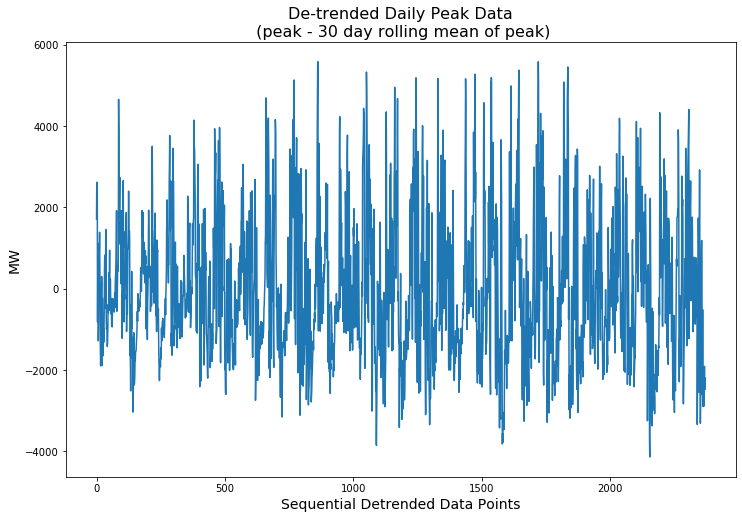

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df2.values)
ax.set_title('De-trended Daily Peak Data\n (peak - 30 day rolling mean of peak)', fontsize=16)
ax.set_ylabel('MW', fontsize=14)
ax.set_xlabel('Sequential Detrended Data Points', fontsize=14)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'detrended-daily-peak-data-full.PNG', bbox_inches='tight')
plt.show();

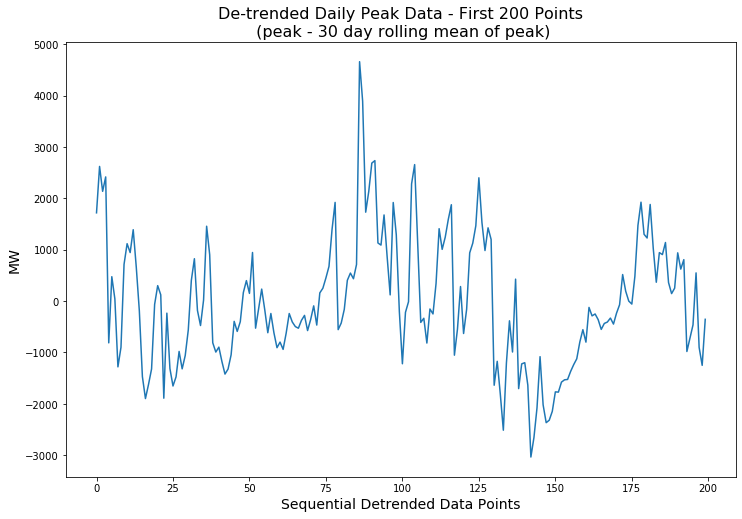

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df2.values[0:200])
ax.set_title('De-trended Daily Peak Data - First 200 Points\n (peak - 30 day rolling mean of peak)', fontsize=16)
ax.set_ylabel('MW', fontsize=14)
ax.set_xlabel('Sequential Detrended Data Points', fontsize=14)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'detrended-daily-peak-data-part.PNG', bbox_inches='tight')
plt.show();

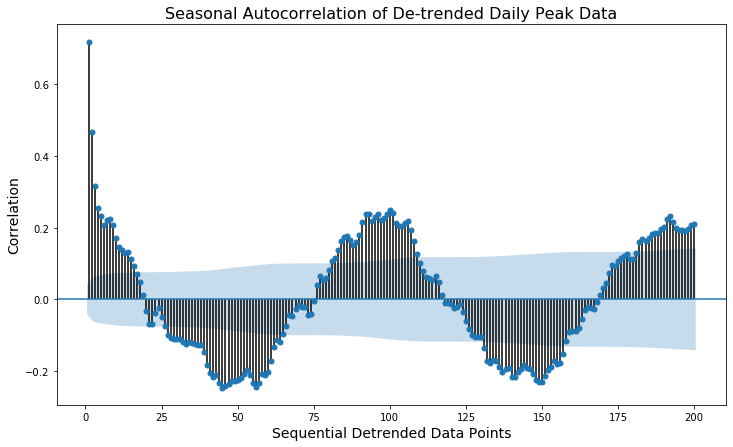

In [14]:
# Create figure and subplots
fig, ax1 = plt.subplots(figsize=(12,7))
# Plot the ACF
plot_acf(df2.values, lags=200, zero=False, ax=ax1)
ax1.set_title('Seasonal Autocorrelation of De-trended Daily Peak Data', fontsize=16)
ax1.set_ylabel('Correlation', fontsize=14)
ax1.set_xlabel('Sequential Detrended Data Points', fontsize=14)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'detrended-daily-peak-data-seasonal-autocorr.PNG', bbox_inches='tight')
plt.show();